# Initial Exploration - Text Track

For illustration purposes and to establish the pipeline for initial exploration, this analysis uses a dataset containing a sample of 10,000 data points.

In [1]:
import os, sys
src_path = os.path.join(os.getcwd(), "utils")
if src_path not in sys.path:
    sys.path.append(src_path)

from data_utils import load_and_clean_data, transform_numeric_features
from imputation_utils import impute_binary_columns
from plotting_utils import plot_numeric_histograms, plot_categorical_bars, plot_target_distribution, plot_confusion_matrix
from text_transformer_utils import TextTransformer, transform_text_features
from modeling_utils import create_preprocessor, run_classification

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
file_path = os.path.join("yelp_dataset", "yelp_reduced.csv")
df = load_and_clean_data(file_path)
print("Unique values for 'price_binary':", df['price_binary'].unique())
print("Unique values for 'attire_binary':", df['attire_binary'].unique())
df.info()

Unique values for 'price_binary': [ 0. nan  1.]
Unique values for 'attire_binary': [ 0. nan  1.]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117807 entries, 0 to 1117806
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   business_review_count   1117807 non-null  int64  
 1   text                    1117807 non-null  object 
 2   average_stars           1117807 non-null  float64
 3   stars                   1117807 non-null  float64
 4   business_stars          1117807 non-null  float64
 5   user_review_count       1117807 non-null  float64
 6   fans                    1117807 non-null  float64
 7   useful_category         1117807 non-null  object 
 8   user_total_votes        1117807 non-null  float64
 9   user_total_compliments  1117807 non-null  float64
 10  parking_count           1117807 non-null  int64  
 11  region_income           1117807 non-null  float64
 12  price_binary   

In [3]:
X = df.drop(columns=['useful_category'])
y = df['useful_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
binary_cols = ['price_binary', 'attire_binary']
X_train, X_test = impute_binary_columns(X_train, X_test, binary_cols)


Imputing missing values for: price_binary
CV scores for price_binary: [0.91170542 0.91167631 0.9110723  0.91228032 0.91024932]
Mean CV accuracy for price_binary: 0.9114
Remaining missing values in train for price_binary: 0
Remaining missing values in test for price_binary: 0

Imputing missing values for: attire_binary
CV scores for attire_binary: [0.96562422 0.96612148 0.96495362 0.965786   0.9654617 ]
Mean CV accuracy for attire_binary: 0.9656
Remaining missing values in train for attire_binary: 0
Remaining missing values in test for attire_binary: 0


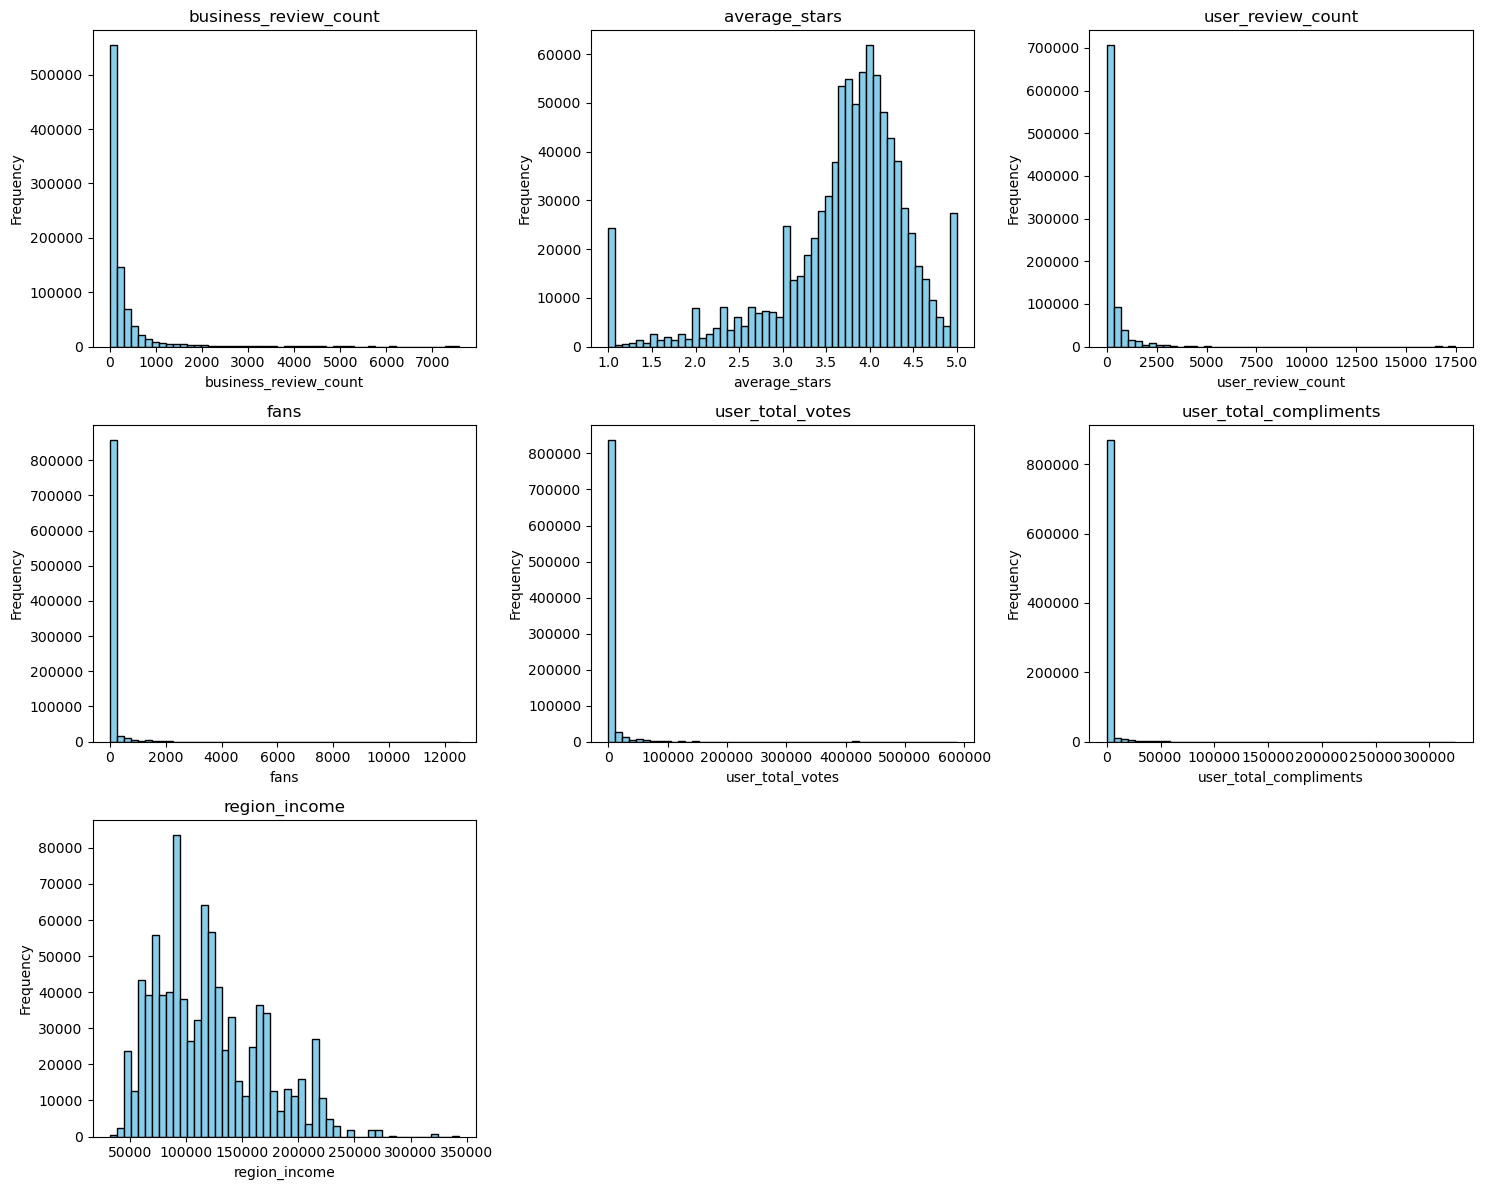

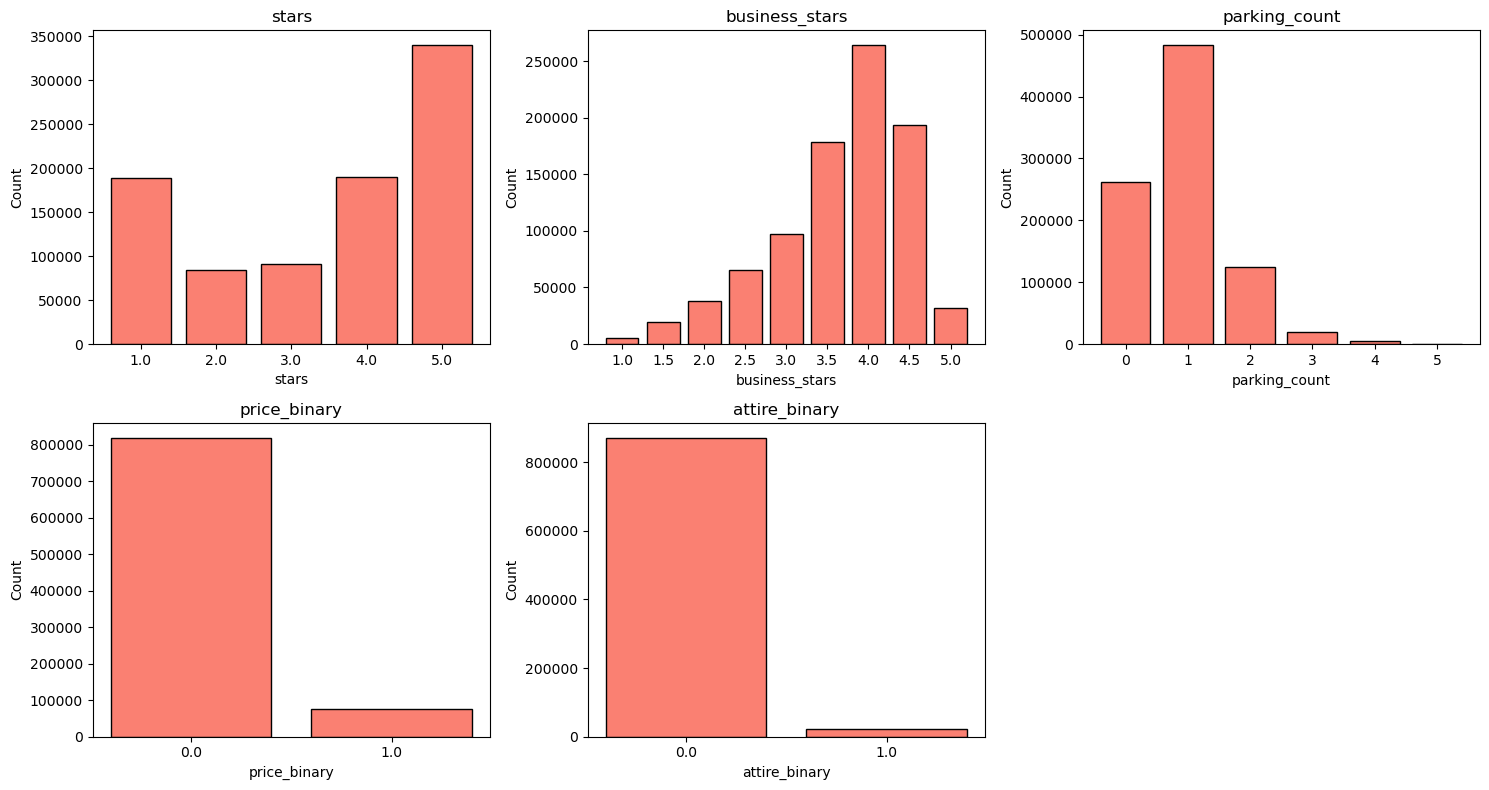

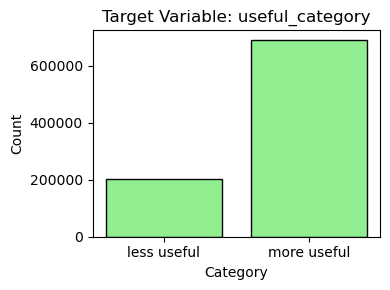

In [5]:
num_cols = ['business_review_count', 'average_stars', 'user_review_count',
            'fans', 'user_total_votes', 'user_total_compliments', 'region_income']
plot_numeric_histograms(X_train, num_cols)

cat_cols = ['stars', 'business_stars', 'parking_count', 'price_binary', 'attire_binary']
plot_categorical_bars(X_train, cat_cols)
plot_target_distribution(y_train, "Target Variable: useful_category")

/Users/apple/Desktop/Math-148-Project/utils/data_utils.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.29334639  0.93232748 -0.1733724  ...  2.03470681 -1.0207339
  2.4579661 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, skewed_features] = X_train_skewed
/Users/apple/Desktop/Math-148-Project/utils/data_utils.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.87772039 -0.76788136  1.85379243 ...  0.54882366  0.4757457
  2.60969149]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, skewed_features] = X_test_skewed
/Users/apple/Desktop/Math-148-Project/utils/data_utils.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.12264527  0.12264527  1.

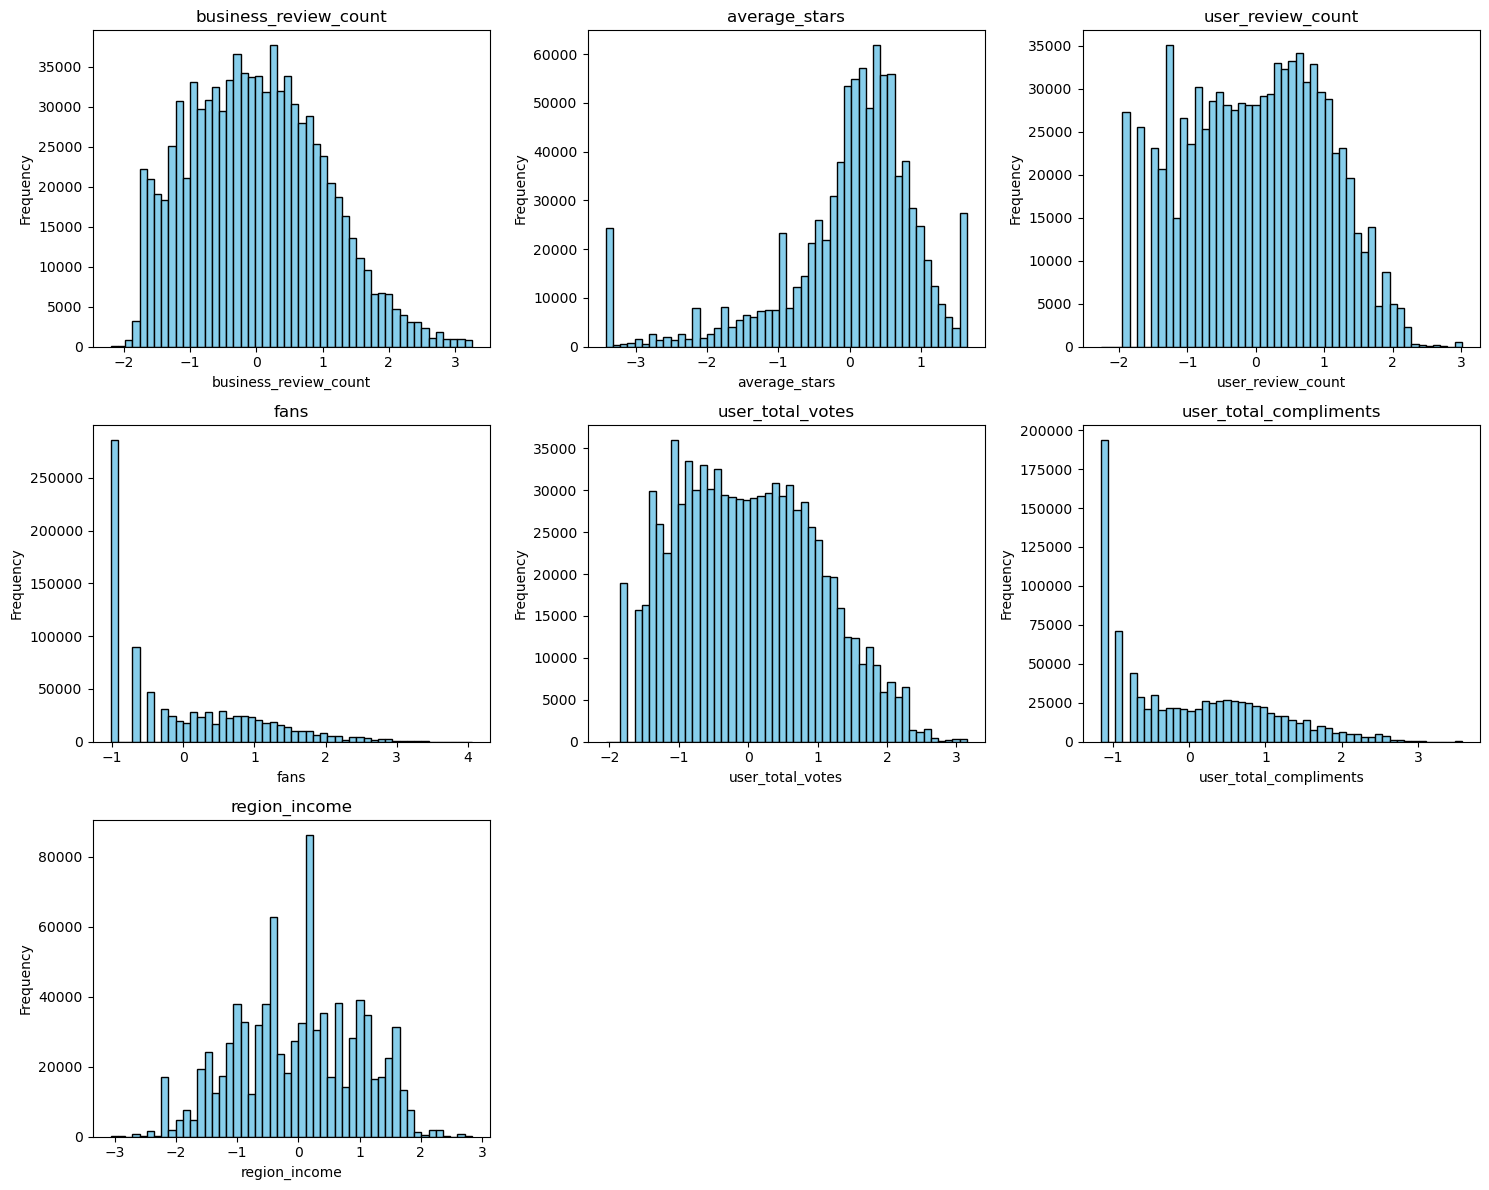

In [6]:
skewed_features = ['business_review_count', 'user_review_count', 'fans', 
                   'user_total_votes', 'user_total_compliments', 'region_income']
numeric_features = ['average_stars', 'business_stars', 'parking_count']
stars_feature = ['stars']
X_train, X_test = transform_numeric_features(X_train, X_test, skewed_features, numeric_features, stars_feature)
plot_numeric_histograms(X_train, num_cols)

In [7]:
text_transformer = TextTransformer(sbert_model_name='all-MiniLM-L6-v2',
                                   pca_components=50, lda_topics=5,
                                   count_max_features=1000, tfidf_max_features=500)
X_train_text, X_test_text = transform_text_features(X_train, X_test, y_train, text_transformer, sample_size=0.1)
print("X_train_transformed shape:", X_train_text.shape)
print("X_test_transformed shape:", X_test_text.shape)

X_train_transformed shape: (894245, 568)
X_test_transformed shape: (223562, 568)


In [8]:
preprocessor = create_preprocessor(X_train_text)
X_train_ready = preprocessor.fit_transform(X_train_text)
X_test_ready = preprocessor.transform(X_test_text)
print("X_train_ready shape:", X_train_ready.shape)
print("X_test_ready shape:", X_test_ready.shape)

X_train_ready shape: (894245, 518)
X_test_ready shape: (223562, 518)



Classification Report:
               precision    recall  f1-score   support

 less useful       0.63      0.47      0.54     51047
 more useful       0.85      0.92      0.89    172515

    accuracy                           0.82    223562
   macro avg       0.74      0.69      0.71    223562
weighted avg       0.80      0.82      0.81    223562


Accuracy: 0.8168695932224618


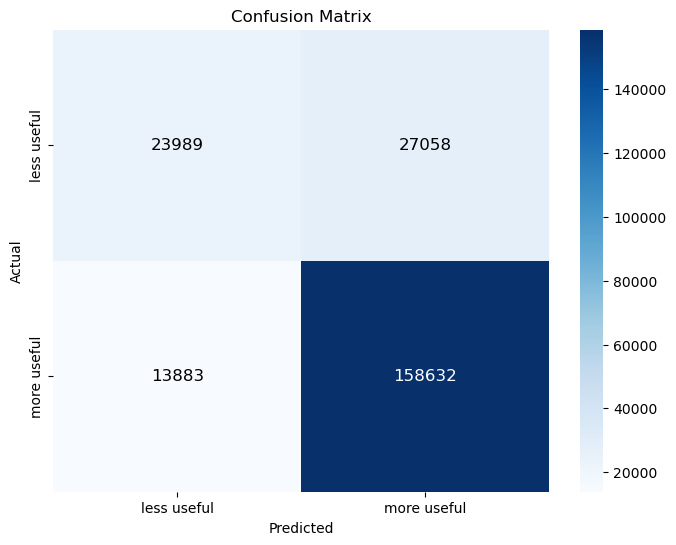

In [9]:
y_pred = run_classification(X_train_ready, y_train, X_test_ready, y_test)
class_labels = sorted(np.unique(y_test))
plot_confusion_matrix(y_test, y_pred, class_labels)